In [49]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, roc_auc_score
from xgboost import XGBClassifier

In [2]:
# Loading dataset 
file_path = 'ckd_data.csv'
data = pd.read_csv(file_path)

In [3]:
data.shape

(6900, 29)

In [9]:
data.sample(2)

,code,type,begin_date,end_date,patient_code,dob,gender,age,outcome,origin,...,Creatinine,Sodium,Potassium,Tot_choresterol,wbc,rbc,hb,dm,ckd,ckd.1
1290,1_659879,visit,6/19/2013,6/19/2013,39075,1/1/1959,F,54.0,good,other hospital,...,80.0,133.5,4.45,5.6,6.5,4.85,14.1,yes,no,no
1014,1_483832,visit,2/15/2012,2/15/2012,29538,1/1/1985,F,27.0,good,other hospital,...,62.0,NaN,NaN,4.6,7.5,4.61,13.1,yes,no,no


In [ ]:
data.info()

In [6]:
def describe_dtypes(data):
    dtype_summary = data.dtypes.value_counts().reset_index()
    dtype_summary.columns = ['dtype', 'num_features']
    
    return dtype_summary
dtype_summary = describe_dtypes(data)
print(dtype_summary)


     dtype  num_features
0   object            19
1  float64             9
2    int64             1


In [7]:
data = data.rename(columns={'ckd.1': 'htn'})

In [8]:
missings = data.isnull().sum()

In [12]:
def evaluate_missingness(data):
    missings = data.isnull().sum()
    missing_data_summary = pd.DataFrame({
        'Column': missings.index,
        'MissingValues': missings.values,
        'perct_missing': (missings.values / len(data) * 100).round(3)
    })
    missing_data_summary.to_csv('missing_data_summary.csv', index = False)
    
    return missing_data_summary

# Example usage
missing_summary = evaluate_missingness(data)


In [ ]:
missing_summary

In [13]:
missing_50 = missing_summary[missing_summary['perct_missing'] >= 0.5 * 100]  # 0.5 = 50/100 as a treshold
print(len(missing_50))

0


# no missing more that 50%

## data fromatting.

In [14]:
def format_data(data):
    # Convert date columns from string to datetime format
    date_columns = ['begin_date', 'end_date', 'dob']
    for col in date_columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')
    
    # Convert specific columns to categorical data type
    category_columns = ['outcome', 'origin', 'insurance', 'ckd', 'dm', 'htn']
    for col in category_columns:
        data[col] = data[col].astype('category')
    
    # Convert numeric columns to numeric data type, coercing errors
    numeric_columns = ['rbc', 'Sodium']
    for col in numeric_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    return data

formatted_data = format_data(data)



In [17]:
formatted_data_summary = describe_dtypes(formatted_data)
print(formatted_data_summary)

            dtype  num_features
0         float64            11
1          object             8
2  datetime64[ns]             3
3        category             3
4           int64             1
5        category             1
6        category             1
7        category             1


In [18]:
def impute_missing(data, n_neighbors=5):
    # Separate numerical, categorical, and datetime columns
    numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
    categorical_columns = data.select_dtypes(include=['category', 'object']).columns.tolist()
    datetime_columns = data.select_dtypes(include=['datetime']).columns.tolist()
    
    # Impute numerical columns using KNN
    numerical_data = data[numerical_columns].copy()
    categorical_data = data[categorical_columns].copy()
    datetime_data = data[datetime_columns].copy()
    
    if not numerical_data.empty:
        imputer = KNNImputer(n_neighbors=n_neighbors)
        imputed_numerical_array = imputer.fit_transform(numerical_data)
        imputed_numerical_data = pd.DataFrame(imputed_numerical_array, columns=numerical_columns, index=numerical_data.index)
    else:
        imputed_numerical_data = numerical_data
    
    # Impute categorical columns using mode
    imputed_categorical_data = categorical_data.apply(lambda col: col.fillna(col.mode()[0]) if col.mode().size > 0 else col)

    # Handle datetime columns
    imputed_datetime_data = datetime_data.fillna(pd.Timestamp('1900-01-01'))  # Replace with a specific date or placeholder if necessary
    
    # Combine imputed numerical, categorical, and datetime data
    imputed_data = pd.concat([imputed_numerical_data, imputed_categorical_data, imputed_datetime_data], axis=1)
    
    # Save the imputed data to a CSV file
    file_path = 'imputed_data.csv'
    imputed_data.to_csv(file_path, index=False)
    
    return imputed_data
imputed_data = impute_missing(formatted_data)

In [22]:
duplicates = imputed_data.duplicated(subset=['patient_code'])
duplicates.value_counts()

True     4230
False    2670
Name: count, dtype: int64

In [67]:
data_unique = imputed_data.drop_duplicates(subset=['patient_code'], keep='first')

In [23]:
def delete_duplicated (data):
    data_unique = imputed_data.drop_duplicates(subset=['patient_code'], keep='first')
    data_unique.to_csv('data_unique.csv', index = False)
    return data_unique
data_unique = delete_duplicated(imputed_data)

In [26]:
data_unique.shape

(2670, 29)

# feature engeneering

In [27]:
def engineer_and_clean_data(data):
    data['days_stay'] = (data['end_date'] - data['begin_date']).dt.days
    data['days_stay'] = data['days_stay'].clip(lower=0) # days cannnot be negative
    data['days_stay'].fillna(data['days_stay'].median(), inplace=True)
    data['city_source'] = data['DISTRICT'].isin(['KICUKIRO', 'NYARUGENGE', 'GASABO'])  # Create 'city_source' column
    data['anemia'] = data['hb'] >= 15.2  # Create 'anemia' column
    data.to_csv('engeneered_data.csv')

    return data
engeneered_data = engineer_and_clean_data (data_unique)

C:\Users\USER\AppData\Local\Temp\ipykernel_5000\793803019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_stay'] = (data['end_date'] - data['begin_date']).dt.days
C:\Users\USER\AppData\Local\Temp\ipykernel_5000\793803019.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_stay'] = data['days_stay'].clip(lower=0) # days cannnot be negative
C:\Users\USER\AppData\Local\Temp\ipykernel_5000\793803019.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [28]:
engeneered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2670 entries, 0 to 6899
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   patient_code     2670 non-null   float64       
 1   age              2670 non-null   float64       
 2   Blood glucose    2670 non-null   float64       
 3   HBA1c            2670 non-null   float64       
 4   Urea             2670 non-null   float64       
 5   Creatinine       2670 non-null   float64       
 6   Sodium           2670 non-null   float64       
 7   Potassium        2670 non-null   float64       
 8   Tot_choresterol  2670 non-null   float64       
 9   wbc              2670 non-null   float64       
 10  rbc              2670 non-null   float64       
 11  hb               2670 non-null   float64       
 12  code             2670 non-null   object        
 13  type             2670 non-null   object        
 14  gender           2670 non-null   object      

In [29]:
df = engeneered_data.copy()

# preprocessing

In [30]:
# delete unnecessary columns. 
cols_to_delete = {'code', 'type.1', 'diagcode'}
df = df.drop(columns=cols_to_delete)

In [31]:
cols_to_delete = {'begin_date', 'end_date', 'dob'}
df = df.drop(columns=cols_to_delete)

In [ ]:
df.info()

In [33]:
def preprocess_and_encode(data, output_file='label_mappings.txt'):
    # Identify categorical columns (object or category dtype)
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Initialize the LabelEncoder
    label_encoders = {}
    mappings = {}
    
    for col in categorical_columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))  # Convert to string to handle all types of categorical data
        label_encoders[col] = le
        mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    
    # Export mappings to a text file
    with open(output_file, 'w') as f:
        for col, mapping in mappings.items():
            f.write(f"Mapping for '{col}': {mapping}\n")
    
    return data

In [34]:
df = preprocess_and_encode(df)

In [35]:
cols_to_delete = {'label', 'DISTRICT'}
df = df.drop(columns=cols_to_delete)

In [ ]:
df.info()

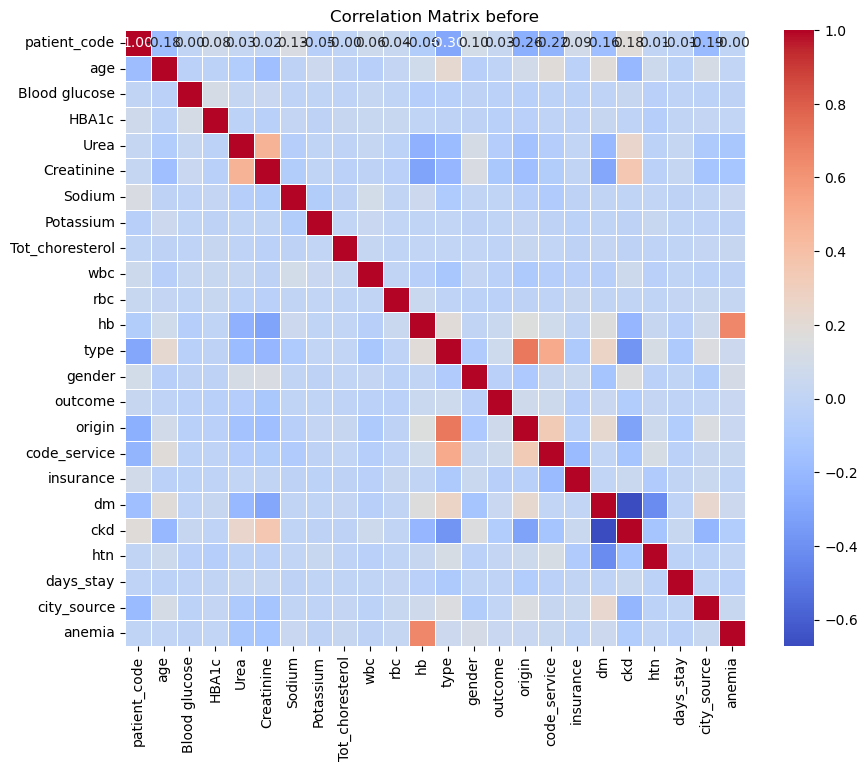

In [37]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix before')
plt.savefig('corr_matrix_before.png')
plt.show()

In [38]:
df['ckd'].value_counts()

ckd
0    2204
1     466
Name: count, dtype: int64

In [44]:
def apply_smote(df, target_column):
    # Check class distribution
    class_counts = df[target_column].value_counts()
    print("Original class distribution:")
    print(class_counts)

    # Separate features (X) and the target column (y)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Apply SMOTE to balance the class distribution
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Convert X_resampled and y_resampled into DataFrames
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    y_resampled_df = pd.DataFrame(y_resampled, columns=[target_column])

    # Combine resampled X and y into a new DataFrame
    resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

    # Check new class distribution
    new_class_counts = resampled_df[target_column].value_counts()
    print("SMOTE class distribution:")
    print(new_class_counts)

    return resampled_df

# Example usage
smote_df = apply_smote(df, 'ckd')

Original class distribution:
ckd
0    2204
1     466
Name: count, dtype: int64
SMOTE class distribution:
ckd
0    2204
1    2204
Name: count, dtype: int64


In [ ]:
now Its time for training. 

we train four models: randomforest classifier, SVM, XGBoost, decision tree classifier,

In [45]:
# splitting the data
def split_data(df, target_column, test_size=0.2, random_state=42):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(dfs, 'ckd', test_size=0.2, random_state=42 )


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
Accuracy: 0.9626
F1 Score: 0.9613
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        98
           1       0.95      0.98      0.96        89

    accuracy                           0.96       187
   macro avg       0.96      0.96      0.96       187
weighted avg       0.96      0.96      0.96       187



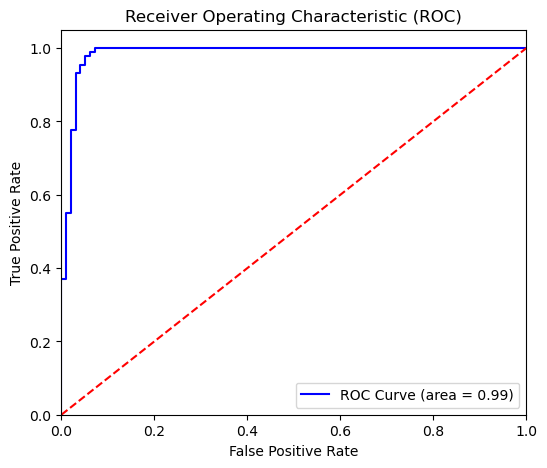

In [56]:
def tune_random_forest(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(random_state=42)

    # Define the hyperparameter grid
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt'],
        'bootstrap': [True, False]
    }

    rf_random = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_dist,
                                   n_iter=100,  # Number of random combinations to try
                                   cv=3,  # Cross-validation
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

    # Fit the model
    rf_random.fit(X_train, y_train)

    # Best estimator
    best_rf_model = rf_random.best_estimator_
    print("Best Hyperparameters:", rf_random.best_params_)

    # Make predictions
    y_pred = best_rf_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # ROC curve
    y_proba = best_rf_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Plot ROC curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.savefig('roc_curve_random_forest.png')  # Save the ROC curve
    plt.show()

    return best_rf_model
best_model_rf = tune_random_forest(X_train, y_train, X_test, y_test)


C:\Users\USER\AppData\Local\anaconda3\envs\Python1\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\USER\AppData\Local\anaconda3\envs\Python1\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\USER\AppData\Local\anaconda3\envs\Python1\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 1.0}
Accuracy: 0.9572
F1 Score: 0.9570
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        98
           1       0.92      1.00      0.96        89

    accuracy                           0.96       187
   macro avg       0.96      0.96      0.96       187
weighted avg       0.96      0.96      0.96       187



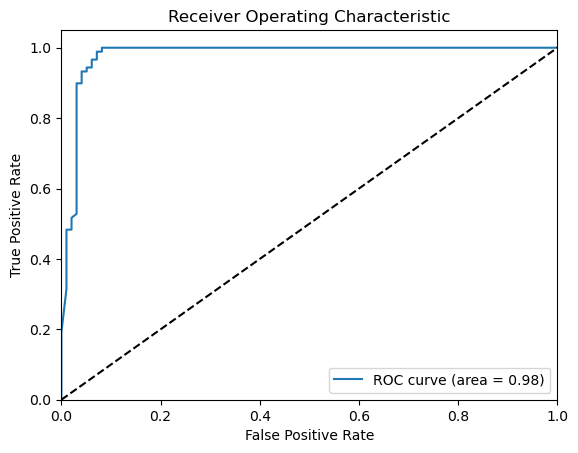

In [57]:
def tune_and_evaluate_xgboost(X_train, y_train, X_test, y_test):
    # Define the model
    xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Define hyperparameter grid for RandomizedSearchCV
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2]
    }

    # Randomized search for hyperparameter tuning
    random_search = RandomizedSearchCV(estimator=xgboost_model,
                                       param_distributions=param_dist,
                                       n_iter=100,
                                       scoring='f1',
                                       cv=3,
                                       verbose=2,
                                       random_state=42,
                                       n_jobs=-1)

    # Fit the model
    random_search.fit(X_train, y_train)

    # Best model from random search
    best_xgboost_model = random_search.best_estimator_

    # Predictions
    y_pred = best_xgboost_model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'Best Parameters: {random_search.best_params_}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(classification_report(y_test, y_pred))

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, best_xgboost_model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('xgboost_roc_curve.png')
    plt.show()

    return best_xgboost_model

best_model_xgb = tune_and_evaluate_xgboost(X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'entropy'}
Accuracy: 0.8396
F1 Score: 0.8333
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        98
           1       0.82      0.84      0.83        89

    accuracy                           0.84       187
   macro avg       0.84      0.84      0.84       187
weighted avg       0.84      0.84      0.84       187



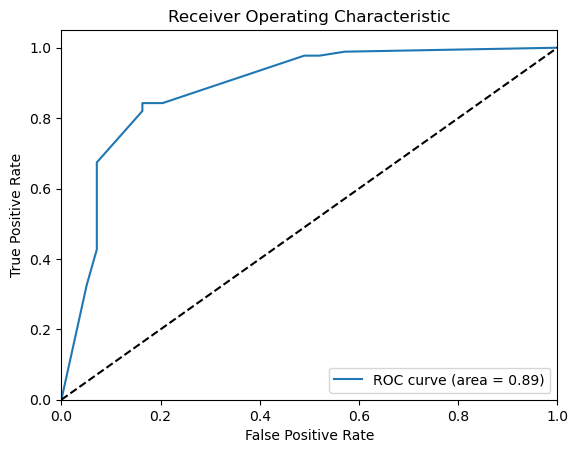

In [59]:
def tune_and_evaluate_decision_tree(X_train, y_train, X_test, y_test):
    # Define the model
    decision_tree_model = DecisionTreeClassifier()

    # Define hyperparameter grid for RandomizedSearchCV
    param_dist = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 3, 5, 7, 9],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    # Randomized search for hyperparameter tuning
    random_search = RandomizedSearchCV(estimator=decision_tree_model,
                                       param_distributions=param_dist,
                                       n_iter=100,
                                       scoring='f1',
                                       cv=3,
                                       verbose=2,
                                       random_state=42,
                                       n_jobs=-1)

    # Fit the model
    random_search.fit(X_train, y_train)

    # Best model from random search
    best_decision_tree_model = random_search.best_estimator_

    # Predictions
    y_pred = best_decision_tree_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'Best Parameters: {random_search.best_params_}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(classification_report(y_test, y_pred))

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, best_decision_tree_model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('decision_tree_roc_curve.png')
    plt.show()

    return best_decision_tree_model

best_model_dt = tune_and_evaluate_decision_tree(X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\USER\AppData\Local\anaconda3\envs\Python1\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\USER\AppData\Local\anaconda3\envs\Python1\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USER\AppData\Local\anaconda3\envs\Python1\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best Parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 400, 'C': 100}
Accuracy: 0.9519
F1 Score: 0.9508
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        98
           1       0.93      0.98      0.95        89

    accuracy                           0.95       187
   macro avg       0.95      0.95      0.95       187
weighted avg       0.95      0.95      0.95       187



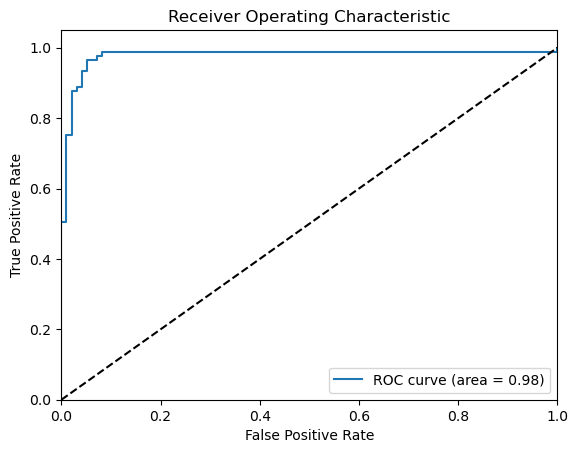

In [60]:
def tune_and_evaluate_logistic_regression(X_train, y_train, X_test, y_test):
    # Define the model
    logistic_model = LogisticRegression(max_iter=1000)

    # Define hyperparameter grid for RandomizedSearchCV
    param_dist = {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 200, 300, 400, 500]
    }

    # Randomized search for hyperparameter tuning
    random_search = RandomizedSearchCV(estimator=logistic_model,
                                       param_distributions=param_dist,
                                       n_iter=100,
                                       scoring='f1',
                                       cv=3,
                                       verbose=2,
                                       random_state=42,
                                       n_jobs=-1)

    # Fit the model
    random_search.fit(X_train, y_train)

    # Best model from random search
    best_logistic_model = random_search.best_estimator_

    # Predictions
    y_pred = best_logistic_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'Best Parameters: {random_search.best_params_}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(classification_report(y_test, y_pred))

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, best_logistic_model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('logistic_regression_roc_curve.png')
    plt.show()

    return best_logistic_model
best_model_lr = tune_and_evaluate_logistic_regression(X_train, y_train, X_test, y_test)

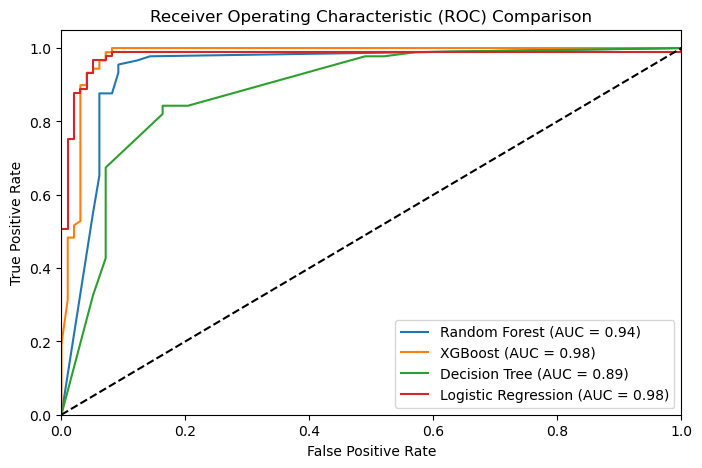

In [61]:
def plot_combined_roc(models, X_test, y_test):
    plt.figure(figsize=(8, 5))
    
    for model_name, model in models.items():
        # Get probabilities for the positive class
        y_probs = model.predict_proba(X_test)[:, 1]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    # Plot the diagonal line
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Comparison')
    plt.legend(loc='lower right')
    plt.savefig('combined_roc_curve.png')
    plt.show()


models = {
    'Random Forest': best_model,
    'XGBoost': best_model_xgb,
    'Decision Tree': best_model_dt,
    'Logistic Regression': best_model_lr
}

plot_combined_roc(models, X_test, y_test)


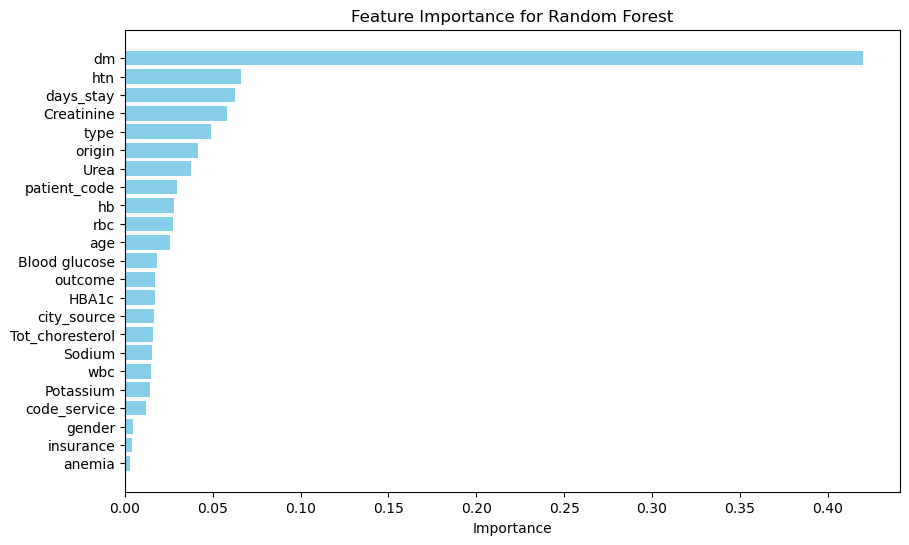

In [64]:
def plot_feature_importance(model, feature_names):
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance for Random Forest')
    plt.gca().invert_yaxis()  # Invert y axis to have the most important features at the top
    plt.savefig('random_forest_feature_importance.png')
    plt.show()

# Example usage:
plot_feature_importance(best_model_rf, X_train.columns)

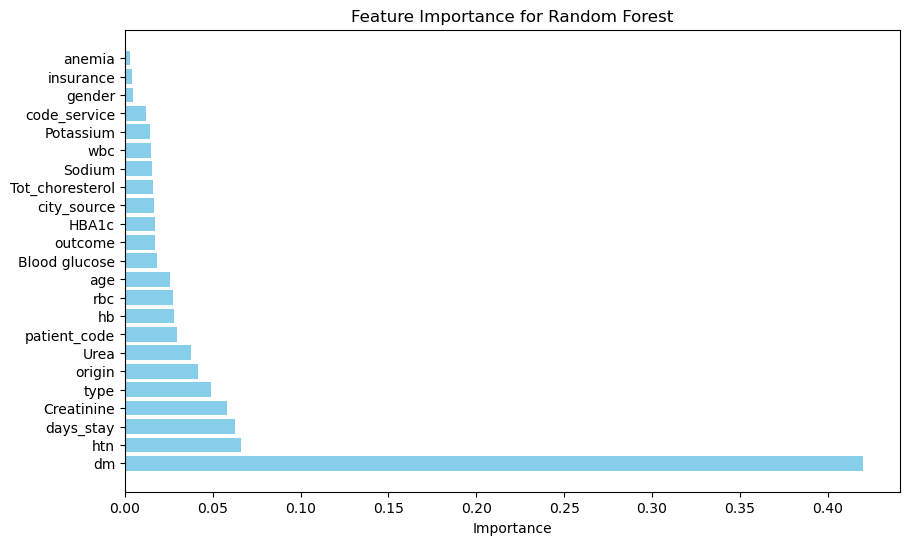

In [65]:
def plot_feature_importance(model, feature_names):
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance for Random Forest')
    #plt.gca().invert_yaxis()  # Invert y axis to have the most important features at the top
    plt.savefig('random_forest_feature_importance.png')
    plt.show()

# Example usage:
plot_feature_importance(best_model_rf, X_train.columns)

In [63]:
import pickle
def save_rf_model(model, filename='ckd_rf_model.pkl'):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Final is model saved as {filename}")

save_rf_model(best_model_rf)



Final is model saved as ckd_rf_model.pkl


# End of the project